In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from econml.dml import LinearDML, CausalForestDML
from econml.metalearners import XLearner, TLearner, SLearner
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
import networkx as nx
from IPython.display import display
import warnings
from econml.dml import CausalForestDML, LinearDML
from xgboost import XGBRegressor, XGBClassifier
import numpy as np
import shap
import numpy as np
import pandas as pd
from econml.metalearners import TLearner, XLearner
from sklearn.ensemble import GradientBoostingClassifier
warnings.filterwarnings('ignore')

pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

train = pd.read_csv('/content/processed_train_data.csv')
test = pd.read_csv('/content/processed_test_data.csv')

# Data Processing for Causal Inference

In [ ]:
print("Dataset dimensions:", train.shape)
print("Columns:", train.columns.tolist())

print("\nBasic dataset statistics:")
print(f"No-show rate: {train['No-show'].mean():.4f}")
print(f"SMS received rate: {train['SMS_received'].mean():.4f}")
print(f"Scholarship rate: {train['Scholarship'].mean():.4f}")
print(f"Average wait time: {train['WaitTime'].mean():.2f} days")

# Create binary WaitTime indicator for easier causal analysis
median_wait = train['WaitTime'].median()
train['HighWaitTime'] = (train['WaitTime'] > median_wait).astype(int)
print(f"Median wait time: {median_wait:.2f} days")

Dataset dimensions: (88421, 117)
Columns: ['PatientId', 'AppointmentID', 'Gender', 'ScheduledDay', 'AppointmentDay', 'Age', 'Scholarship', 'Hipertension', 'Diabetes', 'Alcoholism', 'Handcap', 'SMS_received', 'No-show', 'WaitTime', 'WaitTime_Log', 'WaitTime_Std', 'WaitTime_MinMax', 'WaitTime_Age_Interaction', 'poly_0', 'poly_1', 'poly_2', 'poly_3', 'AppointmentDay_Day', 'AppointmentDay_Month', 'AppointmentDay_Weekday', 'WaitTime_RollingMean_3', 'WaitTime_Lag_1', 'Gender_Encoded', 'NB_ANDORINHAS', 'NB_ANTÔNIO HONÓRIO', 'NB_ARIOVALDO FAVALESSA', 'NB_BARRO VERMELHO', 'NB_BELA VISTA', 'NB_BENTO FERREIRA', 'NB_BOA VISTA', 'NB_BONFIM', 'NB_CARATOÍRA', 'NB_CENTRO', 'NB_COMDUSA', 'NB_CONQUISTA', 'NB_CONSOLAÇÃO', 'NB_CRUZAMENTO', 'NB_DA PENHA', 'NB_DE LOURDES', 'NB_DO CABRAL', 'NB_DO MOSCOSO', 'NB_DO QUADRO', 'NB_ENSEADA DO SUÁ', 'NB_ESTRELINHA', 'NB_FONTE GRANDE', 'NB_FORTE SÃO JOÃO', 'NB_FRADINHOS', 'NB_GOIABEIRAS', 'NB_GRANDE VITÓRIA', 'NB_GURIGICA', 'NB_HORTO', 'NB_ILHA DAS CAIEIRAS', 'NB_IL

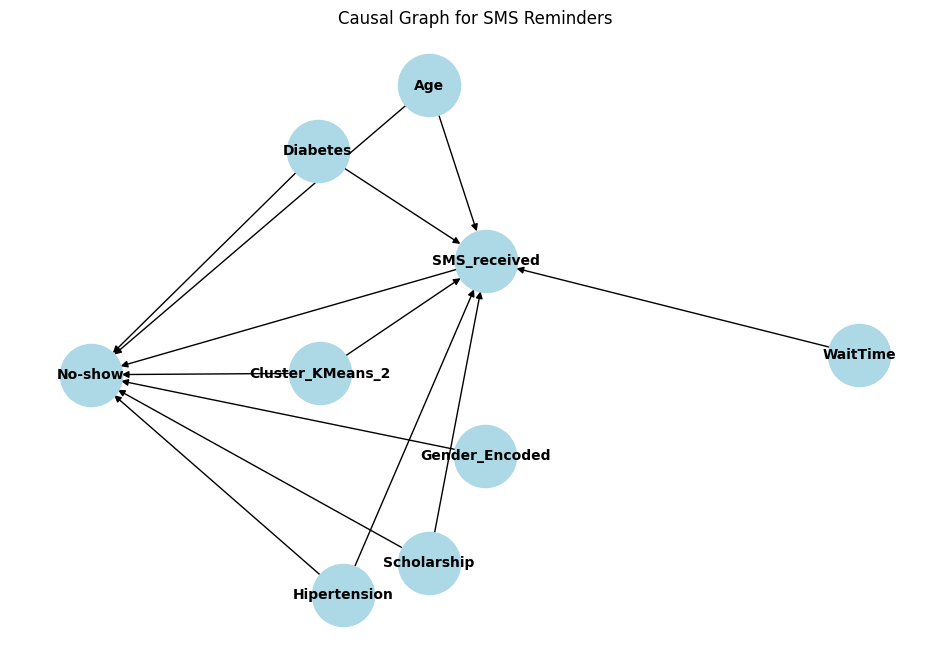

In [ ]:
# =======================================================
# Visual representation of causal relationships
# =======================================================
# Create SMS causal graph
G_sms = nx.DiGraph()
# Add nodes
nodes = ['Age', 'Gender_Encoded', 'Hipertension', 'Diabetes', 'SMS_received',
         'No-show', 'WaitTime', 'Scholarship', 'Cluster_KMeans_2']
G_sms.add_nodes_from(nodes)

# Add edges
edges = [
    ('Age', 'No-show'), ('Gender_Encoded', 'No-show'),
    ('Hipertension', 'No-show'), ('Diabetes', 'No-show'),
    ('SMS_received', 'No-show'), ('Age', 'SMS_received'),
    ('Hipertension', 'SMS_received'), ('Diabetes', 'SMS_received'),
    ('WaitTime', 'SMS_received'), ('Scholarship', 'SMS_received'),
    ('Scholarship', 'No-show'), ('Cluster_KMeans_2', 'No-show'),
    ('Cluster_KMeans_2', 'SMS_received')
]
G_sms.add_edges_from(edges)

# Visualize the causal graph
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G_sms, seed=42)
nx.draw_networkx(
    G_sms,
    pos=pos,
    arrows=True,
    with_labels=True,
    node_color='lightblue',
    node_size=2000,
    font_size=10,
    font_weight='bold'
)
plt.title("Causal Graph for SMS Reminders")
plt.axis('off')
plt.show()

# Do SMS reminders causally reduce no-show rates?

In [ ]:
# 1.1 Initial exploration
print("\n1.1 No-show rates by SMS status:")
sms_groups = train.groupby('SMS_received')['No-show'].agg(['mean', 'count'])
print(sms_groups)


1.1 No-show rates by SMS status:
                  mean  count
SMS_received                 
0             0.166916  60126
1             0.276798  28295


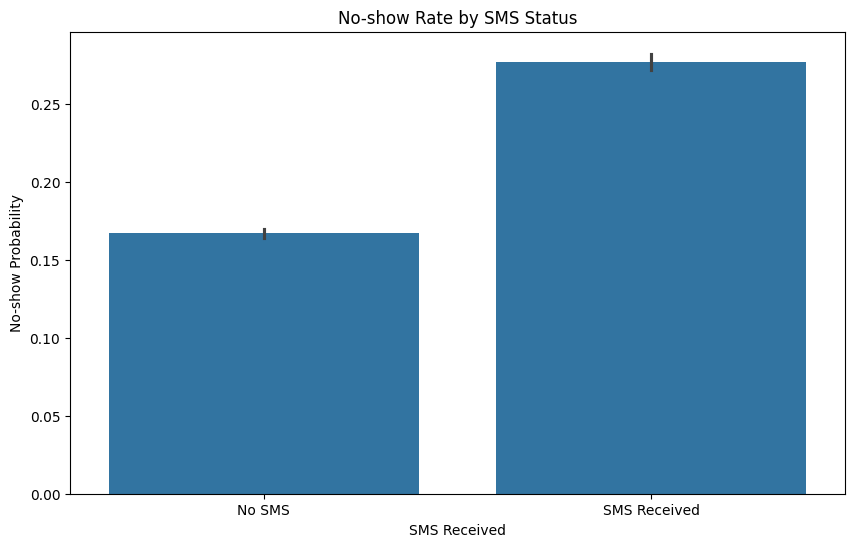

In [ ]:
# 1.2 Visualization of no-show rates by SMS status
plt.figure(figsize=(10, 6))
sns.barplot(x='SMS_received', y='No-show', data=train, errorbar=('ci', 95))
plt.title('No-show Rate by SMS Status')
plt.xlabel('SMS Received')
plt.ylabel('No-show Probability')
plt.xticks([0, 1], ['No SMS', 'SMS Received'])
plt.show()

In [ ]:
# Define core features and treatment columns
core_features = ['Age', 'Gender_Encoded', 'WaitTime', 'Hipertension',
                'Diabetes', 'Alcoholism', 'Handcap', 'Cluster_KMeans_2', 'Scholarship']
treatment_cols = ['SMS_received']


# Verify features exist in the dataset
features = [f for f in core_features if f in train.columns]
print(f"\nUsing features for causal analysis: {features}")


Using features for causal analysis: ['Age', 'Gender_Encoded', 'WaitTime', 'Hipertension', 'Diabetes', 'Alcoholism', 'Handcap', 'Cluster_KMeans_2', 'Scholarship']


## SMOTE for imbalanced data

In [ ]:
# ====================================================
# SMOTE for addressing class imbalance
# ====================================================

# Define features for SMOTE
features_smote = core_features + treatment_cols

df_smote = train[features_smote + ['No-show']].copy()

# Apply SMOTE
smote = SMOTE(random_state=42)
X_sm, Y_sm = smote.fit_resample(df_smote.drop('No-show', axis=1), df_smote['No-show'])
print("\nBefore SMOTE, distribution of No-show outcome:")
print(train['No-show'].value_counts())
print("\nAfter SMOTE, distribution of No-show outcome:")
print(pd.Series(Y_sm).value_counts())

# Update variables for causal ML analyses
X_resampled = X_sm.drop(treatment_cols, axis=1)
T_sms_resampled = X_sm['SMS_received'].values
Y_resampled = Y_sm

# Create a resampled dataframe for visualization
df_resampled = pd.DataFrame(X_resampled, columns=core_features)
df_resampled['SMS_received'] = T_sms_resampled
df_resampled['No-show'] = Y_resampled


Before SMOTE, distribution of No-show outcome:
No-show
0    70553
1    17868
Name: count, dtype: int64

After SMOTE, distribution of No-show outcome:
No-show
0    70553
1    70553
Name: count, dtype: int64


## DML

In [ ]:
# Convert data types for DML
X_dml = X_resampled.copy()
Y_dml = Y_resampled.astype(float)  # DML requires float outcome
T_sms_dml = T_sms_resampled.astype(float)  # DML requires float treatment

# LinearDML implementation
print("\n--- Linear DML Implementation ---")
linear_dml = LinearDML(
    model_y=XGBRegressor(n_estimators=100, random_state=42, objective="reg:squarederror"),
    model_t=XGBClassifier(n_estimators=100, random_state=42, use_label_encoder=False, eval_metric="logloss"),
    discrete_treatment=True,
    cv=5
)

# Fit the Linear DML model
linear_dml.fit(Y_dml, T_sms_dml, X=X_dml)

# Get ATE and confidence intervals
ate_dml = linear_dml.ate(X_dml)  # Returns a scalar, not an array
lower, upper = linear_dml.ate_interval(X_dml)

print(f"Linear DML ATE (SMS effect): {ate_dml:.4f}")
print(f"95% CI: [{lower:.4f}, {upper:.4f}]")

# Get individual treatment effects (CATE)
cate_dml = linear_dml.effect(X_dml)
df_resampled['CATE_DML'] = cate_dml

# CausalForestDML for heterogeneous treatment effects
print("\n--- Causal Forest DML Implementation ---")
forest_dml = CausalForestDML(
    model_y=XGBRegressor(n_estimators=100, random_state=42, objective="reg:squarederror"),
    model_t=XGBClassifier(n_estimators=100, random_state=42, use_label_encoder=False, eval_metric="logloss"),
    discrete_treatment=True,
    n_estimators=100,
    random_state=42
)

# Fit the Causal Forest DML model
forest_dml.fit(Y_dml, T_sms_dml, X=X_dml)

# Get ATE for Causal Forest
ate_forest = forest_dml.ate(X_dml)

print(f"Causal Forest DML ATE (SMS effect): {ate_forest:.4f}")



--- Linear DML Implementation ---
Linear DML ATE (SMS effect): -0.0899
95% CI: [-0.0972, -0.0825]

--- Causal Forest DML Implementation ---
Causal Forest DML ATE (SMS effect): -1.6545


## Meta-Learners

In [ ]:
# ====================================================
# META-LEARNERS: T-LEARNER and X-LEARNER with classifiers
# ====================================================

# --- T-Learner using GradientBoostingClassifier for binary outcome ---
t_learner = TLearner(models=GradientBoostingClassifier(n_estimators=100, random_state=42))
t_learner.fit(Y_resampled, T_sms_resampled, X=X_resampled)
cate_t = t_learner.effect(X_resampled)
print(f"\nT-Learner ATE (SMS effect): {np.mean(cate_t):.4f}")

# --- X-Learner using GradientBoostingClassifier for binary outcome ---
x_learner = XLearner(
    models=GradientBoostingClassifier(n_estimators=100, random_state=42),
    propensity_model=LogisticRegression(max_iter=1000, random_state=42)
)
x_learner.fit(Y_resampled, T_sms_resampled, X=X_resampled)
cate_x = x_learner.effect(X_resampled)
print(f"X-Learner ATE (SMS effect): {np.mean(cate_x):.4f}")

# --- S-Learner for reference ---
s_learner = SLearner(overall_model=GradientBoostingClassifier(n_estimators=100, random_state=42))
s_learner.fit(Y_resampled, T_sms_resampled, X=X_resampled)
cate_s = s_learner.effect(X_resampled)
print(f"S-Learner ATE (SMS effect): {np.mean(cate_s):.4f}")

# Create a DataFrame for CATE analysis
df_resampled['CATE_T'] = cate_t
df_resampled['CATE_X'] = cate_x
df_resampled['CATE_S'] = cate_s


T-Learner ATE (SMS effect): 0.0578
X-Learner ATE (SMS effect): -0.0555
S-Learner ATE (SMS effect): -0.1158


# Placebo Test

In [123]:
# Shuffle the treatment labels (SMS_received) to create a placebo scenario
df_placebo = df_resampled.copy()
df_placebo['SMS_received'] = np.random.permutation(df_placebo['SMS_received'].values)

# Fit T-Learner with placebo treatment
t_learner_placebo = TLearner(models=GradientBoostingClassifier(n_estimators=100, random_state=42))
t_learner_placebo.fit(df_placebo['No-show'], df_placebo['SMS_received'], X=df_placebo[core_features])
cate_t_placebo = t_learner_placebo.effect(df_placebo[core_features])

# Fit X-Learner with placebo treatment
x_learner_placebo = XLearner(models=GradientBoostingClassifier(n_estimators=100, random_state=42))
x_learner_placebo.fit(df_placebo['No-show'], df_placebo['SMS_received'], X=df_placebo[core_features])
cate_x_placebo = x_learner_placebo.effect(df_placebo[core_features])

# Fit S-Learner with placebo treatment
s_learner_placebo = SLearner(overall_model=GradientBoostingClassifier(n_estimators=100, random_state=42))
s_learner_placebo.fit(df_placebo['No-show'], df_placebo['SMS_received'], X=df_placebo[core_features])
cate_s_placebo = s_learner_placebo.effect(df_placebo[core_features])

# Print Placebo ATE results
print(f"Placebo T-Learner ATE: {np.mean(cate_t_placebo):.4f}")
print(f"Placebo X-Learner ATE: {np.mean(cate_x_placebo):.4f}")
print(f"Placebo S-Learner ATE: {np.mean(cate_s_placebo):.4f}")

Placebo T-Learner ATE: 0.0132
Placebo X-Learner ATE: 0.0013
Placebo S-Learner ATE: 0.0000


	•	Placebo T-Learner ATE: 0.0132 → T-Learner is detecting some spurious effects even when treatment labels are randomized. This suggests it may be overfitting or capturing noise.
	•	Placebo X-Learner ATE: 0.0013 → X-Learner’s placebo effect is close to zero, meaning it is much less prone to bias and spurious correlations.
	•	Placebo S-Learner ATE: 0.0000 → S-Learner gives exactly zero, but this is expected because it assumes a single model for both treatment and control, making it less sensitive to treatment effects.


## Conditinoal Average Treatment Effect (CATE) by age groups

In [ ]:
# Create age groups for analysis
age_bins = [0, 18, 40, 65, 100]
age_labels = ['Children', 'Young Adults', 'Adults', 'Elderly']
df_resampled['AgeGroup'] = pd.cut(df_resampled['Age'], bins=age_bins, labels=age_labels)

# Get average CATE by age group
print("\nCausal effect of SMS by age group (T-Learner):")
cate_by_age_t = df_resampled.groupby('AgeGroup')['CATE_T'].mean()
print(cate_by_age_t)

print("\nCausal effect of SMS by age group (X-Learner):")
cate_by_age_x = df_resampled.groupby('AgeGroup')['CATE_X'].mean()
print(cate_by_age_x)


Causal effect of SMS by age group (T-Learner):
AgeGroup
Children        0.298581
Young Adults    0.238507
Adults         -0.137279
Elderly        -0.350519
Name: CATE_T, dtype: float64

Causal effect of SMS by age group (X-Learner):
AgeGroup
Children        0.034327
Young Adults    0.053946
Adults         -0.103458
Elderly        -0.323527
Name: CATE_X, dtype: float64


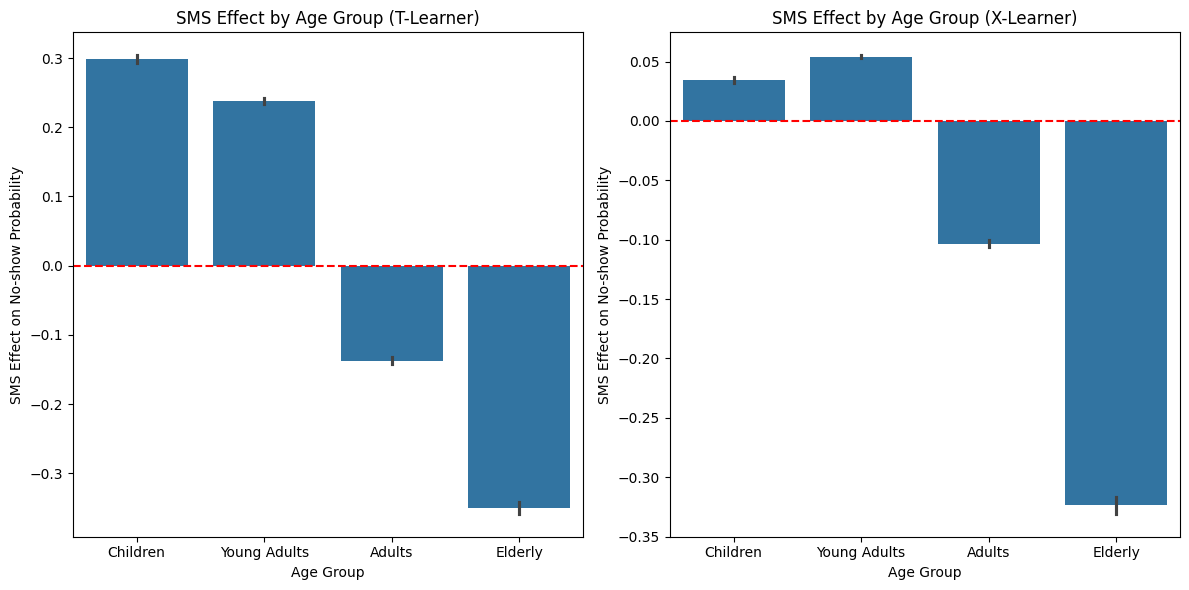

In [116]:
# Plot CATE by Age Group
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.barplot(x='AgeGroup', y='CATE_T', data=df_resampled, estimator=np.mean, errorbar=('ci', 95))
plt.title('SMS Effect by Age Group (T-Learner)')
plt.xlabel('Age Group')
plt.ylabel('SMS Effect on No-show Probability')
plt.axhline(y=0, color='r', linestyle='--')

plt.subplot(1, 2, 2)
sns.barplot(x='AgeGroup', y='CATE_X', data=df_resampled, estimator=np.mean, errorbar=('ci', 95))
plt.title('SMS Effect by Age Group (X-Learner)')
plt.xlabel('Age Group')
plt.ylabel('SMS Effect on No-show Probability')
plt.axhline(y=0, color='r', linestyle='--')
plt.tight_layout()
plt.show()

## Conditinoal Average Treatment Effect (CATE) by sponsorship groups

In [ ]:
# CATE by scholarship status
print("\nCausal effect of SMS by scholarship status (T-Learner):")
cate_by_scholarship_t = df_resampled.groupby('Scholarship')['CATE_T'].mean()
print(cate_by_scholarship_t)

print("\nCausal effect of SMS by scholarship status (X-Learner):")
cate_by_scholarship_x = df_resampled.groupby('Scholarship')['CATE_X'].mean()
print(cate_by_scholarship_x)


Causal effect of SMS by scholarship status (T-Learner):
Scholarship
0    0.056539
1    0.071721
Name: CATE_T, dtype: float64

Causal effect of SMS by scholarship status (X-Learner):
Scholarship
0   -0.057917
1   -0.029422
Name: CATE_X, dtype: float64


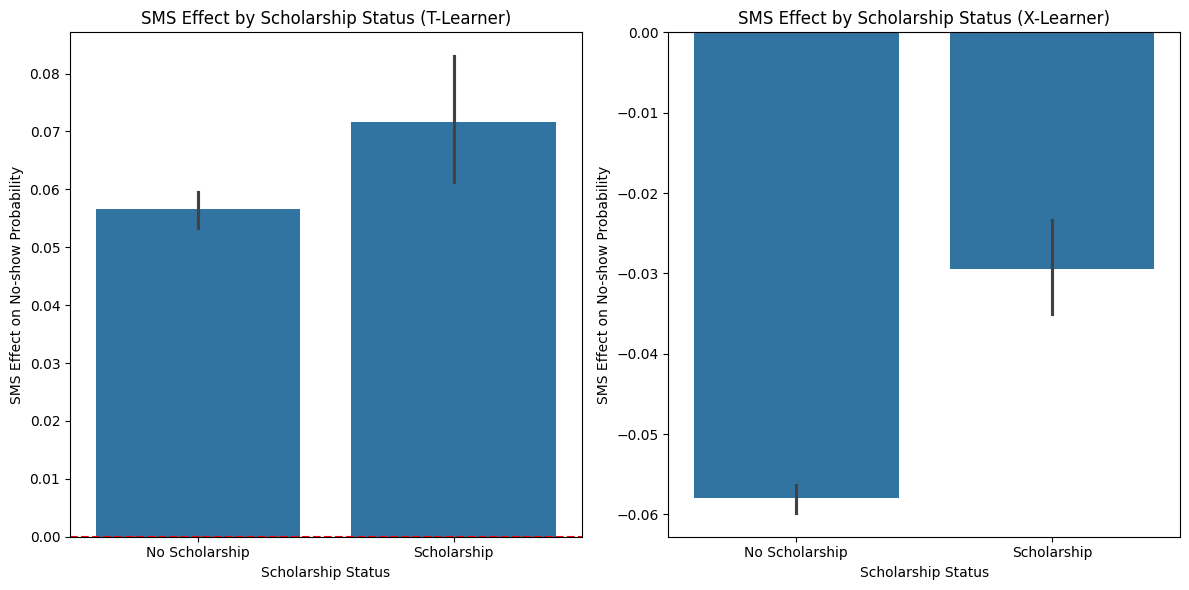

In [ ]:
# Plot CATE by scholarship status
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.barplot(x='Scholarship', y='CATE_T', data=df_resampled, estimator=np.mean, errorbar=('ci', 95))
plt.title('SMS Effect by Scholarship Status (T-Learner)')
plt.xlabel('Scholarship Status')
plt.ylabel('SMS Effect on No-show Probability')
plt.axhline(y=0, color='r', linestyle='--')
plt.xticks([0, 1], ['No Scholarship', 'Scholarship'])

plt.subplot(1, 2, 2)
sns.barplot(x='Scholarship', y='CATE_X', data=df_resampled, estimator=np.mean, errorbar=('ci', 95))
plt.title('SMS Effect by Scholarship Status (X-Learner)')
plt.xlabel('Scholarship Status')
plt.ylabel('SMS Effect on No-show Probability')
plt.axhline(y=0, color='r', linestyle='--')
plt.xticks([0, 1], ['No Scholarship', 'Scholarship'])
plt.tight_layout()
plt.show()

## Conditinoal Average Treatment Effect (CATE) by wait time groups

In [ ]:
# Compute Median Wait Time
median_wait = df_resampled['WaitTime'].median()
df_resampled['HighWaitTime'] = (df_resampled['WaitTime'] > median_wait).astype(int)
print(f"Median wait time: {median_wait:.2f} days")

# CATE by High Wait Time
print("\nCausal effect of SMS by High Wait Time (T-Learner):")
cate_by_high_wait_t = df_resampled.groupby('HighWaitTime')['CATE_T'].mean()
print(cate_by_high_wait_t)

print("\nCausal effect of SMS by High Wait Time (X-Learner):")
cate_by_high_wait_x = df_resampled.groupby('HighWaitTime')['CATE_X'].mean()
print(cate_by_high_wait_x)

Median wait time: 5.00 days

Causal effect of SMS by High Wait Time (T-Learner):
HighWaitTime
0    0.256101
1   -0.154129
Name: CATE_T, dtype: float64

Causal effect of SMS by High Wait Time (X-Learner):
HighWaitTime
0   -0.028370
1   -0.084596
Name: CATE_X, dtype: float64


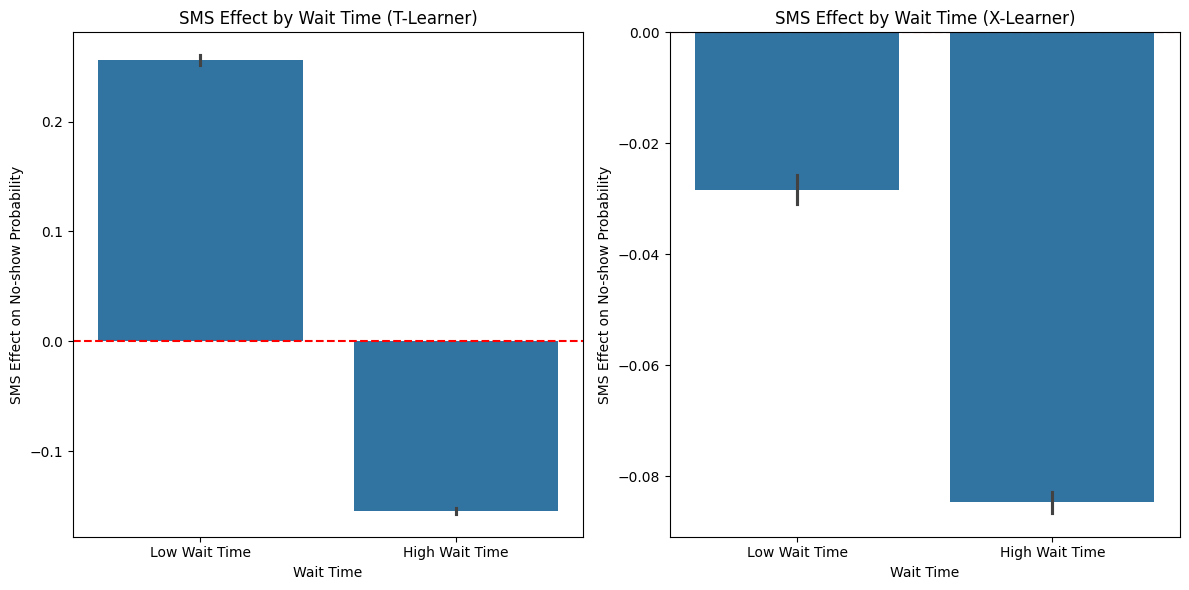

In [ ]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.barplot(x='HighWaitTime', y='CATE_T', data=df_resampled, estimator=np.mean, errorbar=('ci', 95))
plt.title('SMS Effect by Wait Time (T-Learner)')
plt.xlabel('Wait Time')
plt.ylabel('SMS Effect on No-show Probability')
plt.axhline(y=0, color='r', linestyle='--')
plt.xticks([0, 1], ['Low Wait Time', 'High Wait Time'])

plt.subplot(1, 2, 2)
sns.barplot(x='HighWaitTime', y='CATE_X', data=df_resampled, estimator=np.mean, errorbar=('ci', 95))
plt.title('SMS Effect by Wait Time (X-Learner)')
plt.xlabel('Wait Time')
plt.ylabel('SMS Effect on No-show Probability')
plt.axhline(y=0, color='r', linestyle='--')
plt.xticks([0, 1], ['Low Wait Time', 'High Wait Time'])
plt.tight_layout()
plt.show()

# SHAP Analysis

## T-Learner

In [ ]:
# Get treatment and control models
control_model = t_learner.models[0]  # Model trained on control group (T=0)
treatment_model = t_learner.models[1]  # Model trained on treatment group (T=1)

# Convert X_resampled to numpy array for SHAP analysis
X_resampled_array = X_resampled.values
X_resampled_columns = X_resampled.columns

# Create SHAP explainers
explainer_control = shap.TreeExplainer(control_model)
explainer_treatment = shap.TreeExplainer(treatment_model)

# Compute SHAP values for control and treatment groups
shap_values_control = explainer_control.shap_values(X_resampled_array)
shap_values_treatment = explainer_treatment.shap_values(X_resampled_array)

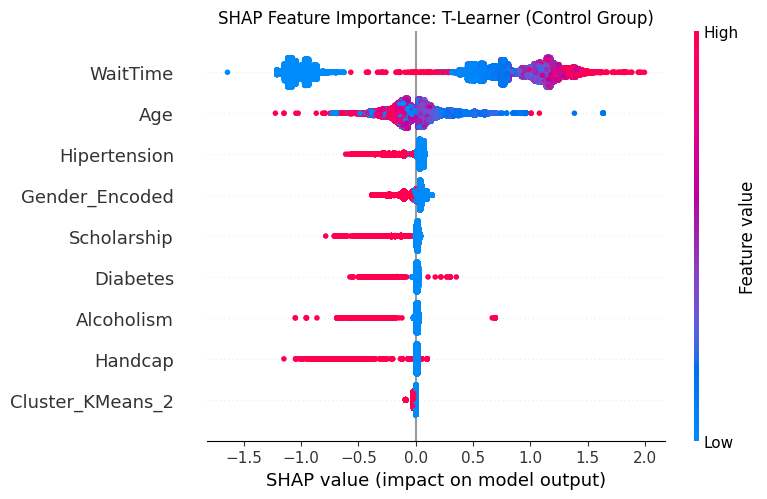

In [ ]:
# Create a function to plot SHAP summary plots
def plot_shap_summary(shap_values, X, columns, title):
    plt.figure(figsize=(12, 8))
    shap.summary_plot(shap_values, X, feature_names=columns, show=False)
    plt.title(title)
    plt.tight_layout()
    plt.show()

# Plot SHAP summary for control group
plot_shap_summary(
    shap_values_control,
    X_resampled_array,
    X_resampled_columns,
    "SHAP Feature Importance: T-Learner (Control Group)"
)

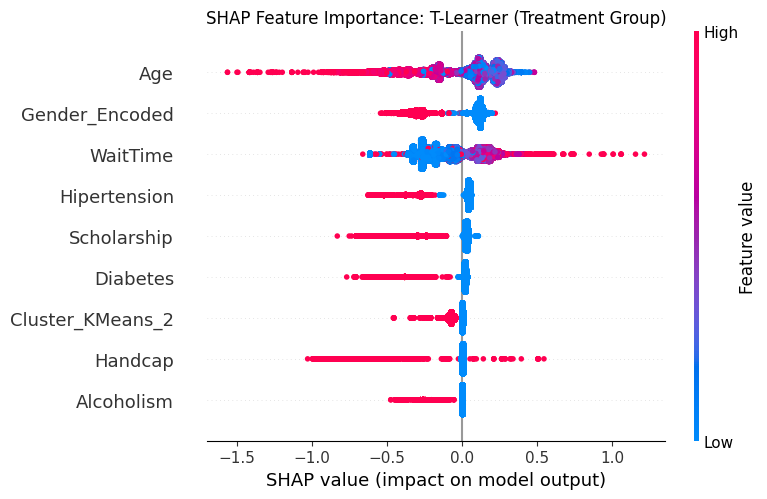

In [ ]:
# Plot SHAP summary for treatment group
plot_shap_summary(
    shap_values_treatment,
    X_resampled_array,
    X_resampled_columns,
    "SHAP Feature Importance: T-Learner (Treatment Group)"
)

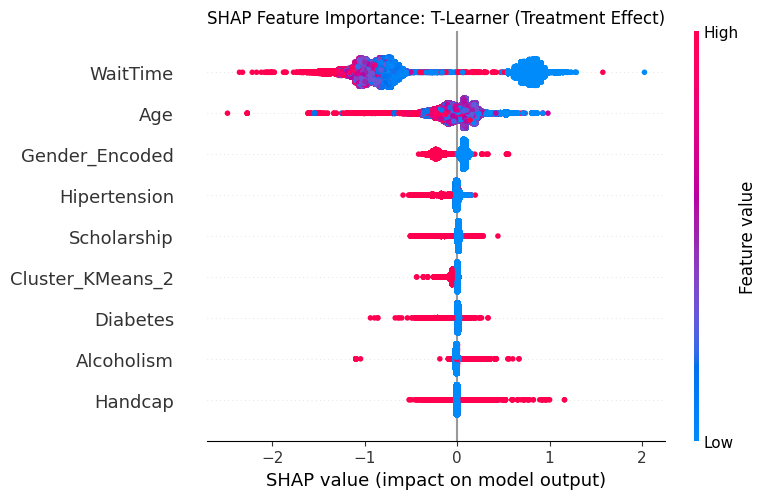

In [ ]:
# Calculate CATE contribution for each feature
cate_contribution = np.array(shap_values_treatment) - np.array(shap_values_control)

# Plot SHAP summary for CATE contribution
plot_shap_summary(
    cate_contribution,
    X_resampled_array,
    X_resampled_columns,
    "SHAP Feature Importance: T-Learner (Treatment Effect)"
)

## X-Learners

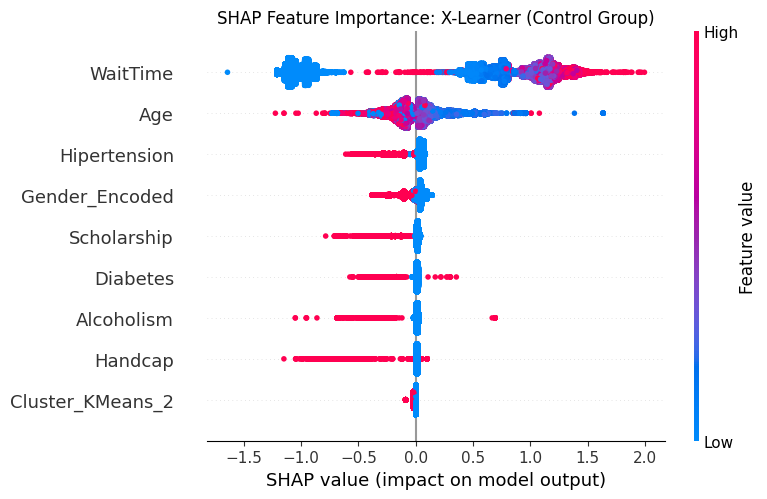

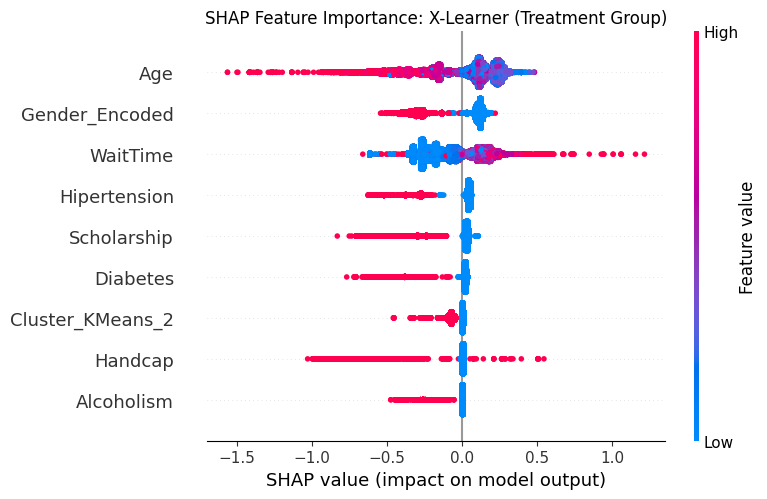

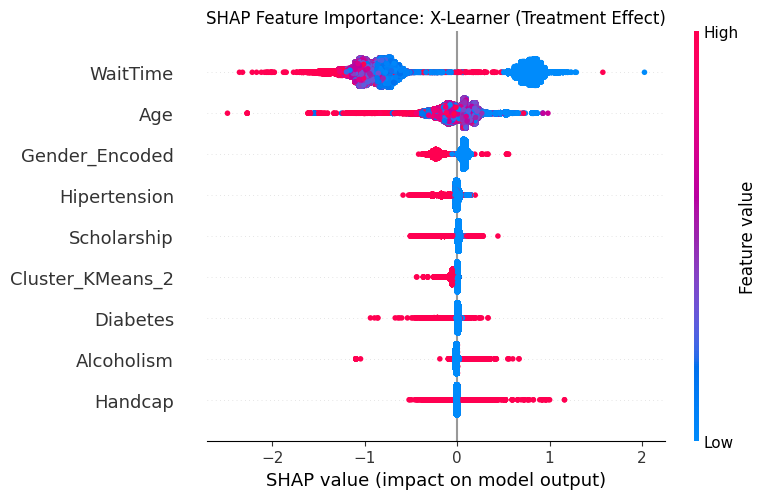

In [125]:
# Get treatment and control models from X-Learner
control_model_x = x_learner.models[0]  # Model trained on control group (T=0)
treatment_model_x = x_learner.models[1]  # Model trained on treatment group (T=1)

# Convert X_resampled to numpy array for SHAP analysis
X_resampled_array = X_resampled.values
X_resampled_columns = X_resampled.columns

# Create SHAP explainers
explainer_control_x = shap.TreeExplainer(control_model_x)
explainer_treatment_x = shap.TreeExplainer(treatment_model_x)

# Compute SHAP values for control and treatment groups
shap_values_control_x = explainer_control_x.shap_values(X_resampled_array)
shap_values_treatment_x = explainer_treatment_x.shap_values(X_resampled_array)

# Plot SHAP summary for control group
plot_shap_summary(
    shap_values_control_x,
    X_resampled_array,
    X_resampled_columns,
    "SHAP Feature Importance: X-Learner (Control Group)"
)

# Plot SHAP summary for treatment group
plot_shap_summary(
    shap_values_treatment_x,
    X_resampled_array,
    X_resampled_columns,
    "SHAP Feature Importance: X-Learner (Treatment Group)"
)

# Calculate CATE contribution for each feature (Treatment - Control)
cate_contribution_x = np.array(shap_values_treatment_x) - np.array(shap_values_control_x)

# Plot SHAP summary for CATE contribution
plot_shap_summary(
    cate_contribution_x,
    X_resampled_array,
    X_resampled_columns,
    "SHAP Feature Importance: X-Learner (Treatment Effect)"
)